In [1]:
from moonbox import *

In [2]:
ods = [parse_oneday(get_oneday(date=f"2024-03-{x}")) for x in range(1, 32)]
ods

[{'Upper Transit': '04:17',
  'Set': '09:19',
  'phase': 'Waning Gibbous',
  'illumination': 69},
 {'Rise': '00:13',
  'Upper Transit': '05:05',
  'Set': '09:50',
  'phase': 'Waning Gibbous',
  'illumination': 60},
 {'Rise': '01:20',
  'Upper Transit': '05:57',
  'Set': '10:30',
  'phase': 'Waning Crescent',
  'illumination': 49},
 {'Rise': '02:25',
  'Upper Transit': '06:54',
  'Set': '11:20',
  'phase': 'Waning Crescent',
  'illumination': 39},
 {'Rise': '03:27',
  'Upper Transit': '07:53',
  'Set': '12:21',
  'phase': 'Waning Crescent',
  'illumination': 29},
 {'Rise': '04:21',
  'Upper Transit': '08:55',
  'Set': '13:33',
  'phase': 'Waning Crescent',
  'illumination': 19},
 {'Rise': '05:07',
  'Upper Transit': '09:55',
  'Set': '14:50',
  'phase': 'Waning Crescent',
  'illumination': 11},
 {'Rise': '05:45',
  'Upper Transit': '10:53',
  'Set': '16:10',
  'phase': 'Waning Crescent',
  'illumination': 4},
 {'Rise': '06:17',
  'Upper Transit': '11:47',
  'Set': '17:29',
  'phase': 'W

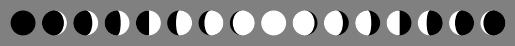

In [101]:
# total area: pi*R^2
# foreground: 0.5*pi*R^2 + 0.5*pi*R*r = 0.5*pi*R^2*(1+r/R)
# f = 0.5*(1+r/R)
# R*(2*f-1)=r

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches

def draw_moon(axes, f, direction):
    center = (0, 0)
    radius = 0.9

    axes.set(aspect=1, xlim=(-1.0, 1.0), ylim=(-1.0, 1.0))
    axes.set_axis_off()

    if f == 0.0:
        back_color = "black"
        half_side = None
        half_color = None
        ellipse_color = None
    elif direction == "waxing" and 0.0 < f < 0.5:
        back_color = "white"
        half_side = "left"
        half_color = "black"
        ellipse_color = "black"
    elif direction == "waxing" and f == 0.5:
        back_color = "white"
        half_side = "left"
        half_color = "black"
        ellipse_color = None
    elif direction == "waxing" and 0.5 < f < 1.0:
        back_color = "black"
        half_side = "right"
        half_color = "white"
        ellipse_color = "white"
    elif f == 1.0:
        back_color = "white"
        half_side = None
        half_color = None
        ellipse_color = None
    elif direction == "waning" and 0.5 < f < 1.0:
        back_color = "black"
        half_side = "left"
        half_color = "white"
        ellipse_color = "white"
    elif direction == "waning" and f == 0.5:
        back_color = "black"
        half_side = "left"
        half_color = "white"
        ellipse_color = None
    elif direction == "waning" and 0.0 < f < 0.5:
        back_color = "white"
        half_side = "right"
        half_color = "black"
        ellipse_color = "black"
    else:
        raise RuntimeError(f"bad values: f={f} direction={direction}")

    back = mpatches.Circle(center, radius, ec="none")
    back.set(color=back_color)
    axes.add_artist(back)

    if half_side == "left":
        half = mpatches.Wedge(center, radius, 90, 270, ec="none")
        half.set(color=half_color)
        axes.add_artist(half)
    elif half_side == "right":
        half = mpatches.Wedge(center, radius, 270, 90, ec="none")
        half.set(color=half_color)
        axes.add_artist(half)

    if ellipse_color is not None:
        artist = mpatches.Ellipse(center, 2*radius * (2*f-1), 2*radius)
        artist.set(color=ellipse_color)
        axes.add_artist(artist)

    return None

n_plots = 16
fig, axs = plt.subplots(1, n_plots)
for i, ax in enumerate(axs):
    phase = i / n_plots

    if 0.0 <= phase <= 0.5:
        f = 2 * phase
        direction = 'waxing'
    elif 0.5 < phase <= 1.0:
        f = 1.0 - 2.0 * (phase - 0.5)
        direction = 'waning'

    draw_moon(axs[i], f, direction)

fig.set_facecolor("0.5")
plt.show()

RuntimeError: bad values: f=69 direction=waning

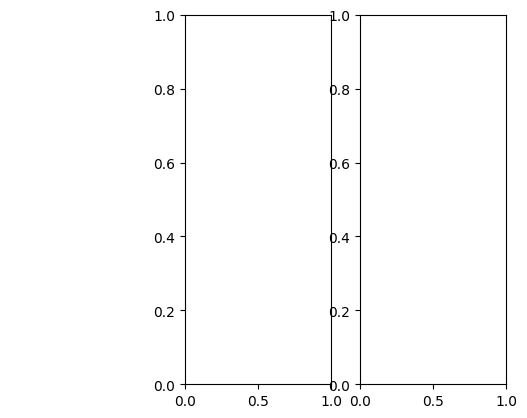

In [102]:
days = [{"f": x['illumination'] / 100, "direction": x['phase'].split()[0].lower()} for x in ods][0:3]

n_plots = len(days)
fig, axs = plt.subplots(1, n_plots)
for i, ax in enumerate(axs):
    draw_moon(axs[i], **days[i])

fig.set_facecolor("0.5")
plt.show()